In [16]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.formula.api as sm
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Read in data
Seperating the attributes from the result

In [11]:
file = pd.read_csv("heart_data.txt")

cols = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
data = pd.DataFrame([file[col] for col in cols]).T
famhist = [1 if val == 'Present' else 0 for val in file['famhist']]
data['famhist'] = famhist
data = pd.DataFrame(zscore(data, ddof=1))
cols.append('famhist')
data.columns = cols

data

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist
0,1.057417,1.821099,0.477894,-0.295183,-0.418017,-0.176594,3.274189,0.628654,1.184570
1,0.276789,-0.789382,-0.159507,0.411694,0.193134,0.670646,-0.612081,1.381617,-0.842361
2,-0.991731,-0.774141,-0.608585,0.883374,-0.112441,0.734723,-0.540597,0.217947,1.184570
3,1.545310,0.841352,0.806252,1.622382,-0.214300,1.411091,0.294742,1.039361,1.184570
4,-0.211103,2.169453,-0.598928,0.305020,0.702427,-0.012842,1.645991,0.423301,1.184570
...,...,...,...,...,...,...,...,...,...
457,3.692037,-0.704470,0.598614,0.811401,1.109862,0.570971,-0.696228,1.039361,-0.842361
458,2.130781,0.122871,-0.159507,0.860240,-0.112441,0.608942,0.068445,0.628654,-0.842361
459,-1.479624,-0.138395,-1.521228,-1.307946,-1.334744,-1.413043,0.391960,0.834008,-0.842361
460,-0.991731,0.384137,3.317227,0.691875,1.109862,0.309916,0.282897,-0.192760,-0.842361


## NN loop
This is the actual loop running the machine learning model

In [12]:
def ANN_model(
        epochs: int, 
        h: int, 
        x_train: object, 
        x_test: object,
        y_train: object,
        y_test: object, 
        n_out: int = 1, 
        lr: float = 0.1,
        confusion: bool = False
    ):
    """
    Function for running (training and testing) ANN model for each k-fold or subset of k-folds
    """
    
    train_loss, test_loss = np.zeros(shape=(epochs)), np.zeros(shape=(epochs))
    try:
        x_train.size(dim=1)
    except:
        print(type(x_train))
    # Defining the model for each fold
    model = nn.Sequential(nn.Linear(x_train.size(dim=1), h),
                          nn.Linear(h, n_out),
                          nn.Tanh())
    loss_function = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Running model
    for i in range(epochs):
        pred_y = model(x_train) # Get prediction for training data
        loss = loss_function(pred_y.flatten(), y_train) # Get loss, based on prediction
        train_loss[i] = loss

        pred_y_test = model(x_test) # Get prediction for test data
        loss_test = loss_function(pred_y_test.flatten(), y_test) # Get loss based on prediction
        test_loss[i] = loss_test
        
        model.zero_grad()
        loss.backward()

        optimizer.step()
    if confusion:
        pred_y_bin = torch.round(pred_y_test)
        conf_mtx = confusion_matrix(y_test.detach().numpy(), pred_y_bin.detach().numpy())
        return train_loss, test_loss, conf_mtx
    
    return train_loss, test_loss


## Logistic regression

In [13]:
def log_reg(
    x_train: object, 
    x_test: object, 
    y_train: object, 
    y_test: object):

    logreg = LogisticRegression(solver='liblinear') #Defining solver
    logreg.fit(x_train,y_train) #Modelfitting

    pred_y_log = logreg.predict(x_test) 

    loss_function_log = nn.MSELoss()

    return 



In [14]:
def kfold_iterations(x_data: object, y_data: object, epochs: int, hidden_neurons: list, k: int = 10, confusion: bool = False):
    
    k_inner = len(hidden_neurons) # Make as many k-folds as there are hidden neurons
    
    best_model_NN = np.zeros(shape=k) # The number of hidden neurons for the best models will be stored here
    
    E_i_NN, final_train_error_NN = np.zeros(shape=k), np.zeros(shape=k) # Error for best model in each k-fold will be stored here
    validation_error_NN = np.zeros(shape=(k_inner, k_inner)) # Error for each inner layer will be stored here
    
    splits_outer = KFold(n_splits = k, shuffle=True, random_state=45) # Defining outer splits
    
    for i, (train_idx_outer, test_idx_outer) in enumerate(splits_outer.split(x_data)): # Outer k-fold layer
        
        # Getting "new" data set for inner k-folds
        x_train_outer, x_test_outer = map(torch.tensor, ((x_data.iloc[train_idx_outer].values), (x_data.iloc[test_idx_outer].values)))
        y_train_outer, y_test_outer = map(torch.tensor, ((y_data.iloc[train_idx_outer].values), (y_data.iloc[test_idx_outer].values)))
        x_train_outer, x_test_outer, y_train_outer, y_test_outer = x_train_outer.float(), x_test_outer.float(), y_train_outer.float(), y_test_outer.float()
        
        
        splits_inner = KFold(n_splits = k_inner, shuffle=True, random_state=42) # Defining inner splits
        
        for j, (train_idx_inner, test_idx_inner) in enumerate(splits_inner.split(x_train_outer)): # Inner k-fold layer
            
            for jj, h in enumerate(hidden_neurons):
                # Training models on inner k-folds
                # Getting the k-folded data
                x_train, x_test = map(torch.tensor, ((x_data.iloc[train_idx_inner].values), (x_data.iloc[test_idx_inner].values)))
                y_train, y_test = map(torch.tensor, ((y_data.iloc[train_idx_inner].values), (y_data.iloc[test_idx_inner].values)))
                x_train, x_test, y_train, y_test = x_train.float(), x_test.float(), y_train.float(), y_test.float()

                _, test_loss_NN = ANN_model(epochs, 
                                            h,
                                            x_train, 
                                            x_test,
                                            y_train,
                                            y_test
                                            )
            
                # We're only interested in the last test error, 
                # as this defines the total loss for the given model
                validation_error_NN[j, jj] = test_loss_NN[-1] 
            
                '''
                Put a function here that runs the linear regression or logistic regression
                for inner k-folds and find the best lambda value for each outer k-fold
                '''
        
        length_ratio = len(x_train_outer) / len(x_data)
        generalization_error_NN = [np.sum(length_ratio * np.array(validation_error_s)) for validation_error_s in validation_error_NN]
        
        # Run model again for outer layer with best h-value from inner layers
        h_best_NN = hidden_neurons[np.argmin(generalization_error_NN)]
        outputs_NN = ANN_model(epochs, 
                            h_best_NN,
                            x_train, 
                            x_test,
                            y_train,
                            y_test,
                            confusion = confusion
                            )
        train_loss_NN, test_loss_NN = outputs_NN[0], outputs_NN[1]
        '''
        Again put the linear or logistic regression model here 
        but this time evaluate on the outer k-fold
        '''
        best_model_NN[i] = h_best_NN
        E_i_NN[i] = test_loss_NN[-1] # Appending last value for test loss in outer layer, this value will go in the final table
        final_train_error_NN[i] = train_loss_NN[-1]
    
    if confusion:
        return final_train_error_NN, E_i_NN, best_model_NN, outputs_NN[2]
    return final_train_error_NN, E_i_NN, best_model_NN

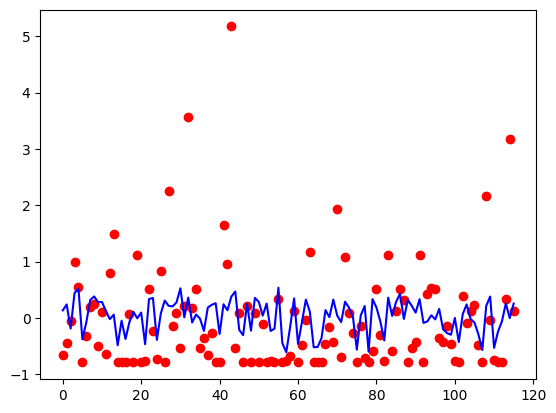

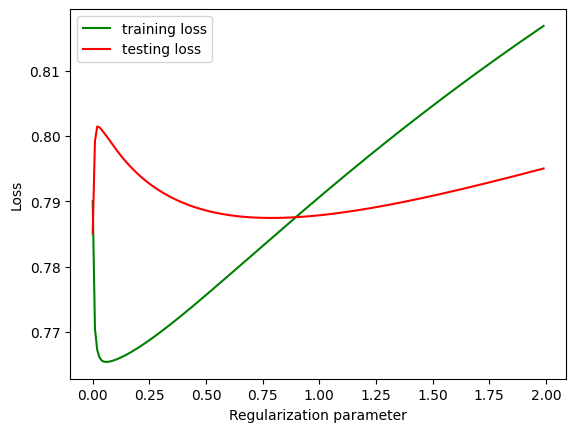

In [43]:
# For linear regression
results = pd.DataFrame(file['chd'])

#Make data a torch tensor
test = data.tobacco
X = data.drop('tobacco', axis = 1)

x = torch.tensor(X.values, dtype = torch.float)
y = torch.tensor(test.values, dtype = torch.float)
y = y.view(y.shape[0],1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=25)

#Model
n_features = len(cols) - 1
input_size = n_features
output_size = 1

model = nn.Linear(input_size, output_size)

#Loss & Optimizer
loss_function = nn.MSELoss()
learning_rate = 0.01

#wd = 0.001 #Use this if not looping

step = []
training_loss = []
testing_loss = []

for wd in np.arange(0,2, 0.01):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = wd)
    
    #Training
    epochs = 100
    for epoch in range(epochs):
        #Forwards pass + loss
        y_predicted = model(X_train.float())
        loss = loss_function(y_predicted, y_train)
        
        #Backwards pass
        loss.backward()
        
        #update
        optimizer.step()
        
        optimizer.zero_grad()
        
#        if (epoch+1) % 100 == 0:
#            print(f'epoch: {epoch+1}, lambda = {wd:.3f}, loss = {loss.item():.4f}')
    
    
    #Testing
    test_predicted = model(X_test.float())
    test_loss = loss_function(test_predicted, y_test)
    test_loss = test_loss.detach()

    step.append(wd)
    training_loss.append(loss.item())
    testing_loss.append(test_loss)

#plot
predicted = model(X_test).detach()
plt.plot(y_test, 'ro')
plt.plot(predicted, 'b')
plt.show()

plt.plot(step, training_loss, 'g', label ='training loss')
plt.plot(step, testing_loss, 'r', label = 'testing loss')
plt.legend()
plt.xlabel('Regularization parameter')
plt.ylabel('Loss')
plt.show()



# Run the whole chebang!! (should take about 10 min)
#data_reg = data.drop("tobacco", axis =1)
#hidden_neurons = np.arange(0, 50, 5) + 1
#train_errors, test_errors, best_model = kfold_iterations(data_reg, data['tobacco'], epochs=200, hidden_neurons=hidden_neurons, k= 5)

In [71]:
# For classification
# Run the whole chebang!! (should take about 10 min)
hidden_neurons = np.arange(0, 50, 5) + 1
train_errors, test_errors, best_model, conf = kfold_iterations(data, file['chd'], epochs=200, hidden_neurons=hidden_neurons, k= 5, confusion=True)

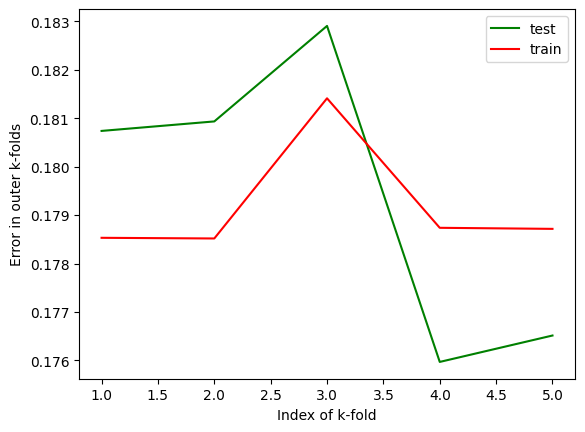

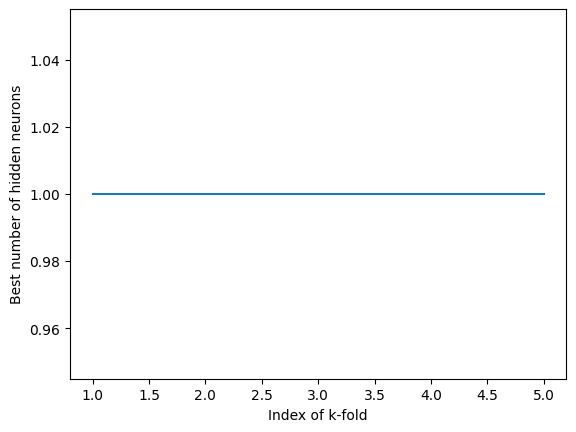

In [72]:
indices = np.arange(1, 6, 1)
plt.plot(indices, test_errors, 'g', label="test")
plt.plot(indices, train_errors, 'r', label="train")
plt.legend()
plt.xlabel("Index of k-fold")
plt.ylabel("Error in outer k-folds")
plt.show()
plt.plot(indices, best_model)
plt.xlabel("Index of k-fold")
plt.ylabel("Best number of hidden neurons")
plt.show()

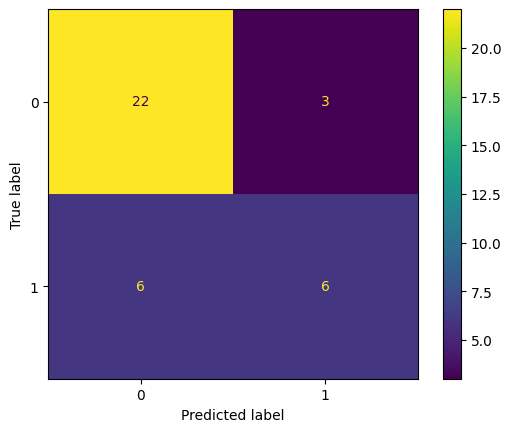

In [76]:
ConfusionMatrixDisplay(conf).plot()

In [51]:
best_model_mean = [round(np.mean(x),) for x in np.split(best_model, 10)]
test_error_mean = [round(np.mean(x),3) for x in np.split(test_errors, 10)]
pd.DataFrame({"h*_i": best_model_mean, "E_i": test_error_mean})

,h*_i,E_i
0,28,0.650
1,30,1.449
2,26,0.971
3,24,1.422
4,28,0.591
5,27,0.559
6,20,0.852
7,29,0.672
8,24,1.192
9,32,0.981


In [12]:
model(data.iloc[2])

NameError: name 'model' is not defined